## Preparation
Make the file structure:

In [1]:
import os, shutil

base_dir = 'data_small'

def rm_dir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(base_dir)

rm_dir(base_dir)

def make_dir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

make_dir(base_dir)

train_dir = os.path.join(base_dir, 'train')
make_dir(train_dir)

train_x_dir = os.path.join(train_dir, 'x')
make_dir(train_x_dir)

train_y_dir = os.path.join(train_dir, 'y')
make_dir(train_y_dir)

val_dir = os.path.join(base_dir, 'val')
make_dir(val_dir)

val_x_dir = os.path.join(val_dir, 'x')
make_dir(val_x_dir)

val_y_dir = os.path.join(val_dir, 'y')
make_dir(val_y_dir)

test_dir = os.path.join(base_dir, 'test')
make_dir(test_dir)

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(dir_name):
    file_names = os.listdir(dir_name)
    
    for file_name in file_names:
        os.remove(os.path.join(dir_name, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

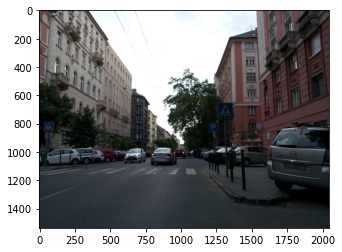

scale(img).shape: (1536, 2048, 3)


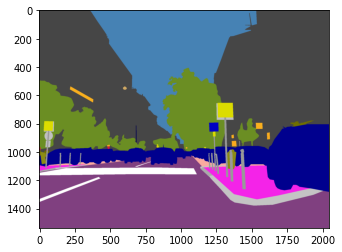

scale(label).shape: (1536, 2048, 3)


In [3]:
from keras import utils
import matplotlib.pyplot as plt

file_name = os.listdir(train_x_dir)[0]
img = utils.load_img(os.path.join(train_x_dir, file_name))
img = utils.img_to_array(img)

def scale(img):
    return img / 255

plt.imshow(scale(img))
plt.show()
print('scale(img).shape: ' + str(scale(img).shape))

file_name = os.listdir(train_y_dir)[0]
label = utils.load_img(os.path.join(train_y_dir, file_name))
label = utils.img_to_array(label)
plt.imshow(scale(label))
plt.show()
print('scale(label).shape: ' + str(scale(label).shape))

We need to convert the label's colors to the categories they're mapped to:

In [4]:
import json

config_file = open('data/config_v2.0.json')
config = json.load(config_file)
labels = config['labels']


{(165, 42, 42): 'animal--bird', (0, 192, 0): 'animal--ground-animal', (250, 170, 31): 'construction--barrier--ambiguous', (250, 170, 32): 'construction--barrier--concrete-block', (196, 196, 196): 'construction--barrier--curb', (190, 153, 153): 'construction--barrier--fence', (180, 165, 180): 'construction--barrier--guard-rail', (90, 120, 150): 'construction--barrier--other-barrier', (250, 170, 33): 'construction--barrier--road-median', (250, 170, 34): 'construction--barrier--road-side', (128, 128, 128): 'object--support--traffic-sign-frame', (250, 170, 35): 'construction--barrier--temporary', (102, 102, 156): 'construction--barrier--wall', (128, 64, 255): 'construction--flat--bike-lane', (140, 140, 200): 'construction--flat--crosswalk-plain', (170, 170, 170): 'object--water-valve', (250, 170, 36): 'construction--flat--driveway', (250, 170, 160): 'construction--flat--parking', (250, 170, 37): 'construction--flat--parking-aisle', (96, 96, 96): 'construction--flat--pedestrian-area', (230,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

